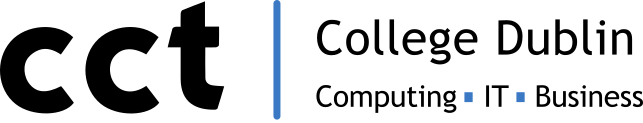

<div style="text-align: center;">
    <h2><u>CA2: Machine Learning for AI</u></h1>
    <h3>Lecturer: David McQuaid</h3>
    <h3>Student Name: Danrlei da Silva Martins</h3>
    <h3>Student Number: 2020322</h3>
    <h3><a href="https://github.com/danrlei-martins-cct/ML_CA2">GitHub Repository</a></h3>
</div>

***

## Assignment Scenario Part I - Neural Networks
- You are required to take data stored file “BankRecords.csv”, available on Moodle and process the data into a DataFrame.
- You are then required to train a Neural Network to predict the “Income(Thousands’)” of the customers, including tuning the network to achieve the best results.
- You must also compare your neural network to a standard ML regressor of your choosing and discuss your findings in the context of the problem at hand.

In [1]:
import pandas as pd

### 1. Data Understanding

In [2]:
# Load dataset
df = pd.read_csv("BankRecords.csv")

In [3]:
# Check the shape (rows, columns)
df.shape

(5000, 14)

In [4]:
# Check first observations
df.head()

,ID,Age,Experience(Years),Income(Thousands's),Sort Code,Family,Credit Score,Education,Mortgage(Thousands's),Personal Loan,Securities Account,CD Account,Online Banking,CreditCard
0,1,25,1,49,91107,4,1.6,Diploma,0,No,Yes,No,No,No
1,2,45,19,34,90089,3,1.5,Diploma,0,No,Yes,No,No,No
2,3,39,15,11,94720,1,1.0,Diploma,0,No,No,No,No,No
3,4,35,9,100,94112,1,2.7,Degree,0,No,No,No,No,No
4,5,35,8,45,91330,4,1.0,Degree,0,No,No,No,No,Yes


In [5]:
# Get summary statistics
df.describe()

,ID,Age,Experience(Years),Income(Thousands's),Sort Code,Family,Credit Score,Mortgage(Thousands's)
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,56.498800
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,101.713802
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,101.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,635.000000


In [6]:
# Check for missing values
df.isna().sum()

ID                       0
Age                      0
Experience(Years)        0
Income(Thousands's)      0
Sort Code                0
Family                   0
Credit Score             0
Education                0
Mortgage(Thousands's)    0
Personal Loan            0
Securities Account       0
CD Account               0
Online Banking           0
CreditCard               0
dtype: int64

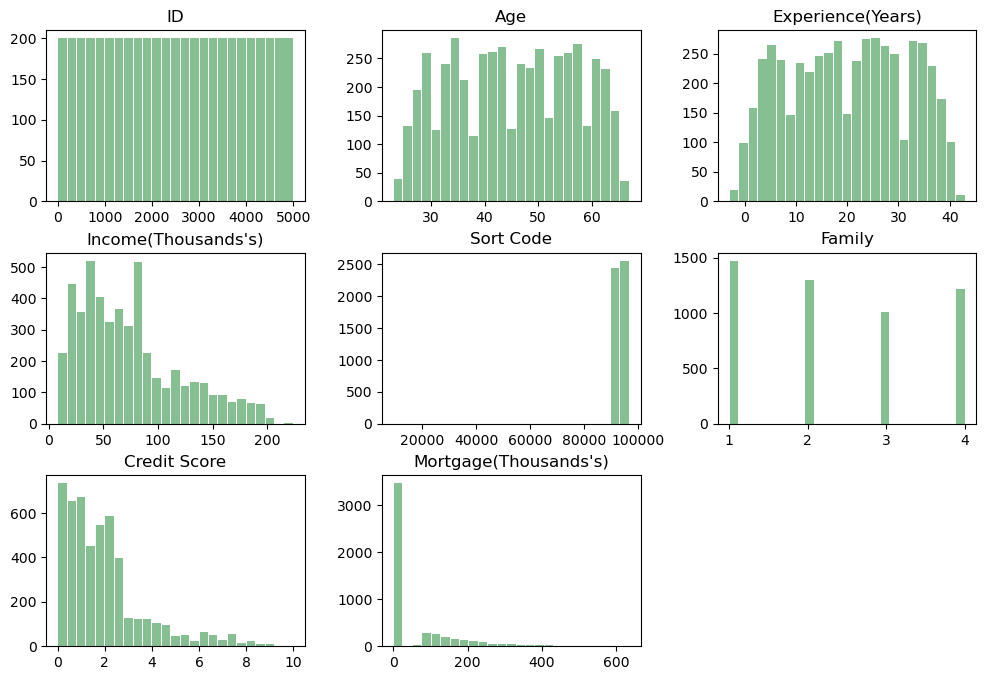

In [7]:
# Display distribution plots
df.hist(bins=25, 
        grid=False, 
        figsize=(12,8), 
        color='#86bf91', 
        zorder=2, 
        rwidth=0.9);

Findings:

- **Negative Values**:  The 'Experience(Years)' column contains negative values, which is unexpected. Experience is typically considered a non-negative quantity. This could potentially indicate data entry errors or outliers that need to be addressed during data preparation.
- **Data Distribution**:
    - Age: The distribution of ages appears to be fairly uniform.
    - Income: The income distribution seems to be right-skewed, with most individuals having lower incomes and a few with significantly higher incomes.
    - Credit Score: The credit score distribution shows a peak around lower values, with a gradual decrease in frequency as scores increase.
    - Mortgage: Most individuals seem to have no mortgage, as indicated by the peak at 0, with a few having higher mortgage amounts, leading to a right-skewed distribution.
- **Data Completeness**: There are no missing values in any of the columns, which is a positive aspect indicating that the dataset is relatively clean in terms of missing data.

***

### 2. Data Preparation

---

## Assignment Scenario Part II - Semantic Analysis
- You are required to source text data from any social media platform on any topic that you choose and perform semantic analysis on the text.
- This analysis should provide a visualization of the overall sentiment of your text data , showing the positive, neutral, and negative sentiment expressed.
- You will require at least 1000 text observations

***

## References